In [1]:
#Import Turing, Distributions, StatsBase, DataFrames and CSV
using Turing, Distributions, StatsBase, DataFrames, CSV

# Import MCMCChain, Plots and StatsPlots
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(12);

# Turn off progress monitor.
Turing.turnprogress(false)

┌ Info: Recompiling stale cache file /home/saumya/.julia/compiled/v1.1/Turing/gm4QC.ji for Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/saumya/.julia/compiled/v1.1/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/saumya/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/saumya/.julia/compiled/v1.1/StatsPlots/SiylL.ji for StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1184
┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /home/saumya/.julia/packages/Turing/RZOZ8/src/Turing.jl:24


false

In [43]:
# Load in the dataset downloaded from https://github.com/inertia7/timeSeries_sp500_R/blob/master/data/data_master_1.csv
#MIT License
df = CSV.read("../data/DowJones.csv")
df[:sp_500]
# plot(df[:Date], df[Symbol("Adj Close")])

252-element CSV.Column{Float64,Float64}:
  464.5475003
  479.0725098
  493.987503 
  507.725006 
  523.650009 
  538.8050078
  553.680008 
  560.649994 
  573.7274933
  582.0299835
  594.1499938
  612.3074953
  621.354996 
    ⋮        
 2028.592499 
 2050.415039 
 2082.582459 
 2081.859925 
 2099.35492  
 2089.485046 
 2086.920044 
 2014.084992 
 1945.722504 
 1996.757538 
 2074.259979 
 2056.099976 

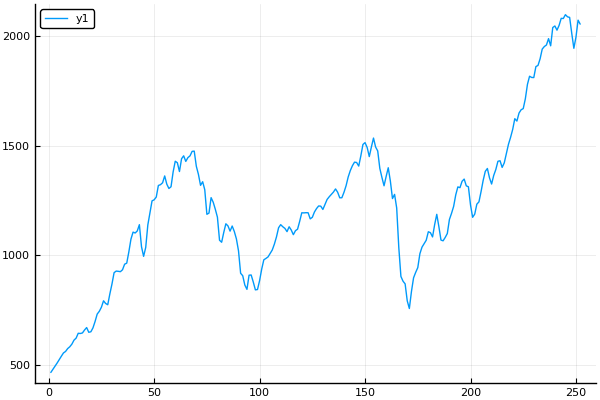

In [46]:
s = Float64[]
for ele in df[:sp_500]
# for ele in df[Symbol("Adj Close")]
    push!(s, ele)
end
pyplot()
plot(s)

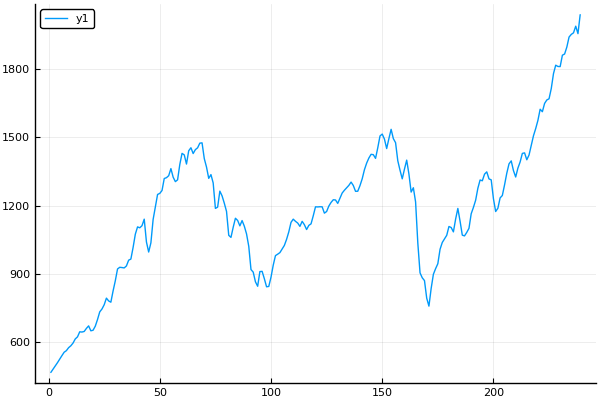

In [47]:
# Split into training and test sets. We will predict for the next 4 days using the data from the past 32 days
train_percentage = 0.95
s_train = s[1:floor(Int, train_percentage*length(s))]
N = length(s_train)

# Plot the training data
plot(s_train)

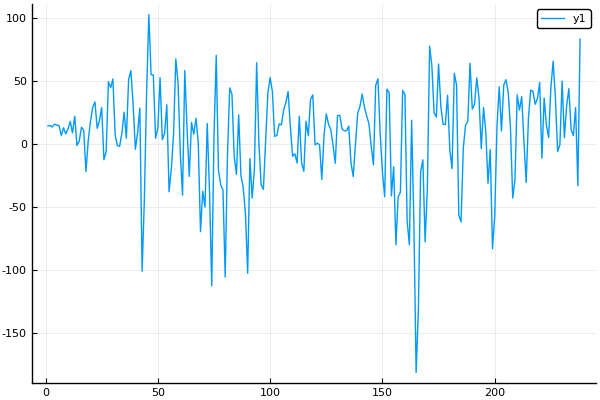

In [56]:
s_diff = diff(s_train)
N_diff = length(s_diff)
plot(s_diff)

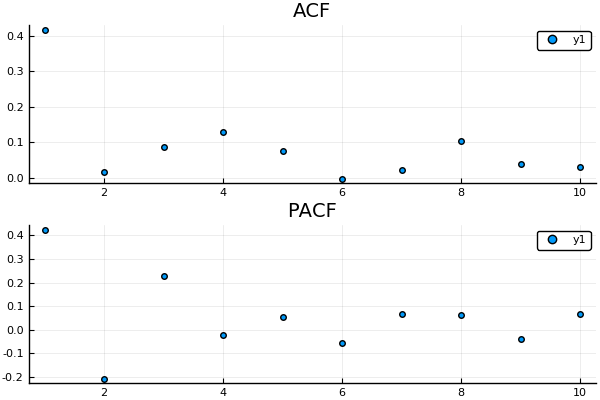

In [57]:
#Plot ACF and PACF plots
total_lags = 10
s1 = scatter(collect(1:total_lags), autocor(s_diff, collect(1:total_lags)), title = "ACF")
s2 = scatter(collect(1:total_lags), pacf(s_diff, collect(1:total_lags)), title = "PACF")
plot(s1, s2, layout = (2, 1))
# The PACF plot cuts off at k = 2, so we will have an AR(2) model for this dataset.

In [61]:
#Defining the model
σ = 1
@model ARIMA110(x, N) = begin
    beta_1 ~ Uniform(-1, 1)
    for t in 3:N
        μ = rand(Normal(0, 1)) + beta_1 * x[t-1] 
        x[t] ~ Normal(μ, 1) 
    end
end;

In [62]:
# This is temporary while the reverse differentiation backend is being improved.
Turing.setadbackend(:forward_diff)

# Sample using NUTS
chain_ARIMA110 = sample(ARIMA110(s_diff, N_diff), NUTS(500, 200, 0.65) )

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/RZOZ8/src/inference/support/hmc_core.jl:247
┌ Info: [Turing] found initial ϵ: 0.013751817867756977
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/RZOZ8/src/inference/support/hmc_core.jl:239
┌ Info:  Adapted ϵ = 3.304583970254928e-52, std = [1.0]; 200 iterations is used for adaption.
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/RZOZ8/src/inference/adapt/adapt.jl:90


[NUTS] Finished with
  Running time        = 15.562674659999988;
  #lf / sample        = 0.0;
  #evals / sample     = 0.002;
  pre-cond. metric    = [1.0].


Object of type Chains, with data of type 500×7×1 Array{Union{Missing, Float64},3}

Log evidence      = 0.0
Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = elapsed, epsilon, eval_num, lf_eps, lf_num, lp
parameters        = beta_1

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean     │ std        │ naive_se   │ mcse       │ ess     │
│     │ Symbol     │ Float64  │ Float64    │ Float64    │ Float64    │ Any     │
├─────┼────────────┼──────────┼────────────┼────────────┼────────────┼─────────┤
│ 1   │ beta_1     │ 0.832446 │ 8.91241e-5 │ 3.98575e-6 │ 9.12274e-6 │ 6.46448 │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%    │ 50.0%    │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64  │ Float64  │ Float64  │ Float64  │ Float64  │
├─────┼────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 1   │ beta_1     │ 0.832437 │ 0.832437 │ 0.832437 │ 

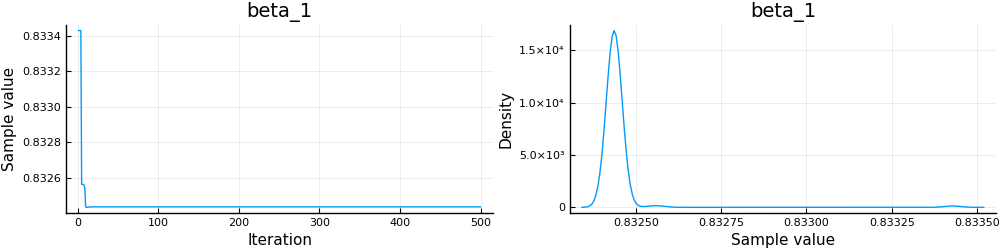

In [63]:
plot(chain_ARIMA110)

In [72]:
#Define the model

σ = 1
@model ARIMA011(x, N) = begin
    beta_1 ~ Uniform(-1, 1)
    μ ~ Uniform(0, 10)
    for t in 3:N
        val = μ + rand(Normal(0,σ)) + beta_1 * rand(Normal(0, 1)) 
        x[t] ~ Normal(val, 1) 
    end
end;

In [73]:
# This is temporary while the reverse differentiation backend is being improved.
Turing.setadbackend(:forward_diff)

# Sampling using NUTS
chain_ARIMA011 = sample(ARIMA011(s_diff, N_diff), NUTS(500, 200, 0.65) )

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/RZOZ8/src/inference/support/hmc_core.jl:247
┌ Info: [Turing] found initial ϵ: 0.12612381037484327
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/RZOZ8/src/inference/support/hmc_core.jl:239
┌ Info:  Adapted ϵ = 2.455674080136074e-50, std = [1.0, 1.0]; 200 iterations is used for adaption.
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/RZOZ8/src/inference/adapt/adapt.jl:90


[NUTS] Finished with
  Running time        = 16.20330450199999;
  #lf / sample        = 0.0;
  #evals / sample     = 0.002;
  pre-cond. metric    = [1.0, 1.0].


Object of type Chains, with data of type 500×8×1 Array{Union{Missing, Float64},3}

Log evidence      = 0.0
Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = elapsed, epsilon, eval_num, lf_eps, lf_num, lp
parameters        = beta_1, μ

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 2 columns
│ Row │ parameters │ mean     │ std         │ naive_se   │ mcse       │
│     │ Symbol     │ Float64  │ Float64     │ Float64    │ Float64    │
├─────┼────────────┼──────────┼─────────────┼────────────┼────────────┤
│ 1   │ beta_1     │ 0.471601 │ 4.76174e-5  │ 2.12951e-6 │ 6.12119e-6 │
│ 2   │ μ          │ 5.90304  │ 0.000528805 │ 2.36489e-5 │ 1.78288e-5 │

Quantiles

│ Row │ parameters │ 2.5%    │ 25.0%    │ 50.0%    │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64 │ Float64  │ Float64  │ Float64  │ Float64  │
├─────┼────────────┼─────────┼──────────┼──────────┼──────────┼──────────┤
│ 1   │ beta_1    

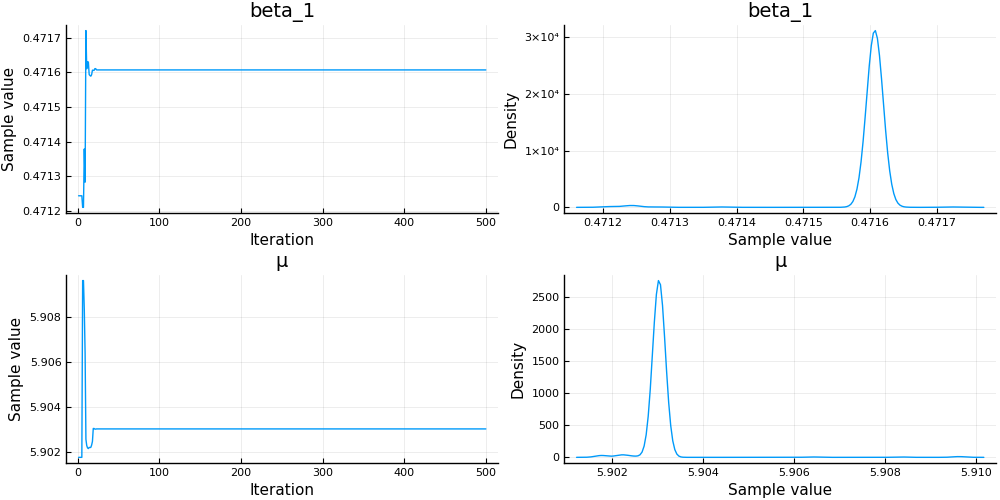

In [74]:
plot(chain_ARIMA011)

In [76]:
# ARIMA 011 WAIC calculation

sampling_size = 500
lpppd = 0.0
p = 0.0
for i = 1:N
    likelihood = Float64[]
    for sample = 1:sampling_size
        beta_1_value = chain_ARIMA011[:beta_1][sample] 
#         mu_value = chain_ARIMA011[:mu][sample,i,:]
#         dist = Normal(mu_value + eta_value[1]*tau_value, sigma[i])
        push!(likelihood, pdf(dist, y[i]) )
    end
    
    # Adding the contribution of the current observation in lpppd
    log_mean = log(mean(likelihood))
    lpppd += log_mean
    
    #Calculating the p_waic value
    log_likelihood = log.(likelihood)
    var_likelihood = var(log_likelihood)
    p += var_likelihood
end

#Applying the above mentioned equation to get the final WAIC value
waic = -2*(lpppd - p);

UndefVarError: UndefVarError: y not defined